In [6]:
import numpy as np
import pandas as pd
import os

featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(24)
n_companies = 16
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)
companies

['450c40bc1e47',
 '43b9e9b21999',
 '5d0389d3507e',
 'ef1bcca724f3',
 'e2415cb7f63d',
 '695b1e497540',
 'dfe2fbf1ed01',
 '61bbe440bf3e',
 '8ded09ca1316',
 '5cc1b4f7fbbd',
 '8a5419583f31',
 'a4a7c48a5224',
 '8b8937c0ca2a',
 '7cc4ff7756ca',
 'fa56db6320bb',
 'f726f3251b6d']

In [7]:
def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features

,43b9e9b21999_d1,450c40bc1e47_d1,5cc1b4f7fbbd_d1,5d0389d3507e_d1,61bbe440bf3e_d1,695b1e497540_d1,7cc4ff7756ca_d1,8a5419583f31_d1,8b8937c0ca2a_d1,8ded09ca1316_d1,...,7cc4ff7756ca_d1p2,8a5419583f31_d1p2,8b8937c0ca2a_d1p2,8ded09ca1316_d1p2,a4a7c48a5224_d1p2,dfe2fbf1ed01_d1p2,e2415cb7f63d_d1p2,ef1bcca724f3_d1p2,f726f3251b6d_d1p2,fa56db6320bb_d1p2
trans_date,,,,,,,,,,,,,,,,,,,,,
2016-01-03,0.153394,1.126519,-0.257617,0.749284,-1.731042,-0.953709,0.999516,0.832737,-0.197762,-0.108332,...,0.000141,-0.111715,-0.207426,-0.271463,0.113454,-0.355706,-0.455991,-0.227909,-0.535753,-0.466253
2016-01-04,0.306090,-0.593880,-0.873041,0.445937,-0.792155,-0.192471,0.824923,0.563625,0.086920,0.092648,...,-0.084822,-0.252385,-0.213989,-0.272532,-0.038728,-0.569739,0.204591,-0.045997,0.795125,0.724053
2016-01-05,-0.427090,0.627787,0.704377,-1.077827,0.295060,-0.034277,-0.577735,-0.376778,-0.122491,-0.816843,...,-0.177658,-0.320399,-0.212563,-0.090549,-0.236897,-0.588694,-0.428922,-0.558307,-0.160178,-0.171871
2016-01-06,3.259942,-0.083743,-0.178350,0.940855,-0.092583,-0.163761,-0.293687,-0.035151,0.058012,-0.365272,...,-0.243558,-0.371863,-0.214918,-0.237752,-0.231628,-0.381105,-0.386357,-0.555381,0.022288,-0.414907
2016-01-07,0.943124,-0.663587,-0.330227,-0.408863,0.348265,0.081296,0.361322,0.314533,0.111950,-0.455175,...,-0.231557,-0.334523,-0.212894,-0.217384,-0.291852,-0.284193,-0.458018,-0.505699,-0.392178,-0.244946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-05,-1.167242,-0.809505,0.890456,-1.466426,1.048305,0.823506,-1.464053,-1.678634,0.589447,0.421827,...,0.304488,0.672446,-0.140213,-0.226306,-0.289767,2.464769,-0.342963,1.418361,-0.472898,-0.268718
2022-11-06,-0.274171,-0.927866,-0.519144,1.341586,-1.450512,-1.058501,0.365764,0.887083,-0.189813,0.139461,...,-0.230694,-0.076761,-0.208084,-0.269592,-0.279771,-0.037455,-0.397590,0.523841,0.111832,-0.515272
2022-11-07,0.242661,0.589771,-0.352480,-0.000227,-0.334375,-0.369904,0.872455,0.182436,-0.293469,-1.210612,...,-0.063301,-0.359332,-0.197364,0.129321,-0.278521,-0.214831,-0.348708,4.274949,0.056141,-0.160009


In [8]:
import tensorflow as tf
import keras
import random
import numpy as np
from data_generation import gen_data
from pyod.utils import pairwise_distances_no_broadcast
from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, dense_run, temporalize, reconstruction

In [11]:
# total_time = 30000
seq_size = 25
n_feature = features.shape[1]

data = features.values
test_size = 0.2
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers = lstm_run(
    data_train_seq,
    data_test_seq,
    n_feature,
    batch_size=100,
    seq_size=seq_size,
    epoch=300,
    metric="bb", 
    early_stopping=False
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")


Epoch 1/300
20/20 [==============================] - 8s 135ms/step - loss: 0.9456
Epoch 2/300
20/20 [==============================] - 3s 133ms/step - loss: 0.9342
Epoch 3/300
20/20 [==============================] - 3s 134ms/step - loss: 0.9285
Epoch 4/300
20/20 [==============================] - 3s 135ms/step - loss: 0.9231
Epoch 5/300
20/20 [==============================] - 3s 136ms/step - loss: 0.9157
Epoch 6/300
20/20 [==============================] - 3s 135ms/step - loss: 0.9150
Epoch 7/300
20/20 [==============================] - 3s 135ms/step - loss: 0.9084
Epoch 8/300
20/20 [==============================] - 3s 137ms/step - loss: 0.9031
Epoch 9/300
20/20 [==============================] - 3s 137ms/step - loss: 0.8982
Epoch 10/300
20/20 [==============================] - 3s 136ms/step - loss: 0.8892
Epoch 11/300
20/20 [==============================] - 3s 138ms/step - loss: 0.8843
Epoch 12/300
20/20 [==============================] - 3s 140ms/step - loss: 0.8821
Epoch 13/300


INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


15/15 [==============================] - 1s 24ms/step
Data test shape (501, 48)
lstm_pred shape (501, 48)


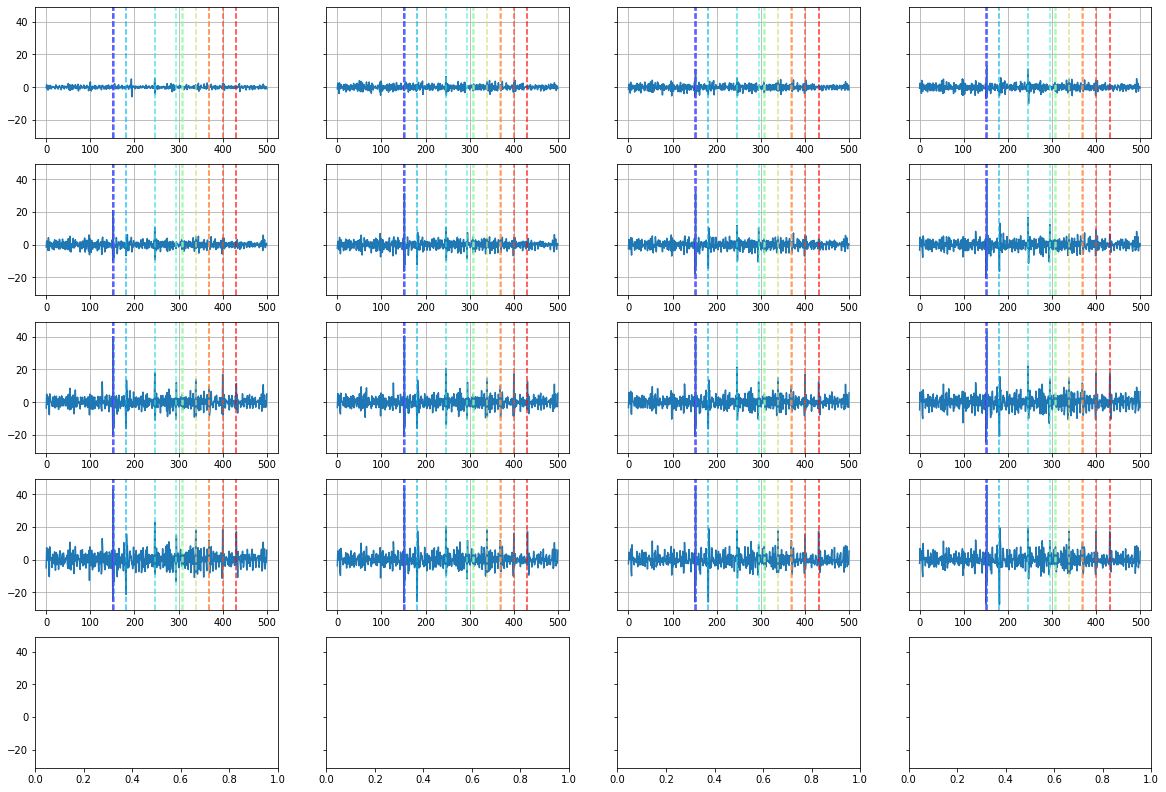

In [13]:
from class_simulationhelper import SimulationHelpers 

sim = SimulationHelpers()
sim.plot(
    # *lstm_pred.T[:len(companies)], 
    # *data_test.T[:6],
    *np.cumsum(data_test,axis = 1).T[:n_companies],
    outliers = [lstm_outliers for _ in range(n_companies)], 
    row_lim=4
)

In [10]:
def bb_outlier(l, std_mult = 2.576):
    ub = np.mean(l) + np.std(l) * std_mult
    lb = np.mean(l) - np.std(l) * std_mult
    return [idx for idx in range(len(l)) if l[idx] >= ub or l[idx] <= lb]

l = np.random.normal(size = 1000)
bb_outlier(l)

[84, 167, 200, 361, 379, 573, 586, 598, 667, 746, 966]